In [29]:
import os, time

import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython import display
import glob

import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam


In [30]:
IMAGE_CHANNELS = 3
GENERATE_RESOLUTION_FACTOR = 3
GENERATE_SQUARE = 32 * GENERATE_RESOLUTION_FACTOR
img_height = 64
img_width = 64

# Preview image details
PREVIEW_ROWS, PREVIEW_COLS = 4, 7
PREVIEW_MARGIN = 16

# Source vector size to generate images
SEED_SIZE = 100

# Model configuration
DATA_PATH = './cartoonset100k/'
FOLDER_NAME = '*/*'

EPOCHS = 50
BATCH_SIZE = 64
BUFFER_SIZE = 61000
print(f"Image details: {GENERATE_SQUARE}px")

Image details: 96px


In [31]:
img_paths = glob.glob("cartoonset10k/*.png")
num_images = len(img_paths)
images = np.zeros((num_images, GENERATE_SQUARE, GENERATE_SQUARE, 3), dtype=np.float32)

In [32]:
for i, path in enumerate(img_paths):
    with Image.open(path) as img:
        img = img.convert("RGB").resize((GENERATE_SQUARE,GENERATE_SQUARE),Image.ANTIALIAS)
        img = np.array(img, dtype=np.float32) / 127.5 - 1
        images[i] = img


/var/folders/bq/_63515l56bbcxdr7gvzr_m740000gn/T/ipykernel_32975/1919887365.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.convert("RGB").resize((GENERATE_SQUARE,GENERATE_SQUARE),Image.ANTIALIAS)


In [33]:
# images = np.load('cartoon_set.npy')

In [34]:
# Save the preprocessed images as .npy file
np.save("cartoon_set10k.npy", images)

In [35]:
# Create a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices(images)
dataset = dataset.shuffle(buffer_size=BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [36]:
dataset.element_spec

TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


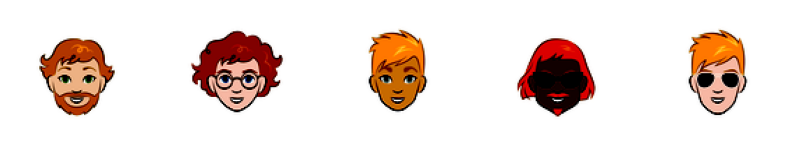

In [38]:
import matplotlib.pyplot as plt

# Load preprocessed image data
data = np.load('cartoon_set10k.npy')

# Display a sample of 50 images
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10,20))
for i, ax in enumerate(axes.flat):
    ax.imshow(data[i], cmap='gray')
    ax.axis('off')
plt.show()

In [39]:
data.shape

(10000, 96, 96, 3)

In [40]:
def build_generator(seed_size, channels):
  model = Sequential()

  model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Reshape((4, 4, 256)))
  
  model.add(Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 8, 8, 256)
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 16, 16, 256)
  model.add(BatchNormalization())
  model.add(LeakyReLU())


  model.add(Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 32, 32, 256)
  model.add(BatchNormalization())
  model.add(LeakyReLU())


  model.add(Conv2DTranspose(64, (5, 5), strides=(3, 3), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 96, 96, 64)
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 96, 96, 3)
  
  return model

In [42]:
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2,
                     padding="same", input_shape=image_shape))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.7))
    model.add(LeakyReLU(alpha=0.3))

    model.add(Dropout(0.2))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.2))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.7))
    model.add(LeakyReLU(alpha=0.3))

    model.add(Dropout(0.2))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [43]:

def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  
  fig = plt.figure(figsize=(15,15))
  plt.imshow(im)
  plt.show()
  im.save(filename)

Generated image shape:  (1, 96, 96, 3)


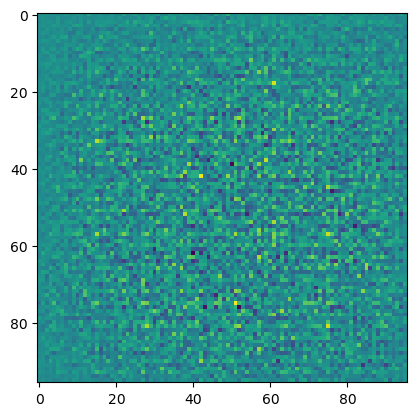

In [44]:
generator = build_generator(SEED_SIZE,3)
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)
print("Generated image shape: ", generated_image.shape)

plt.imshow(generated_image[0, :, :, 0])

In [45]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.4999486]], shape=(1, 1), dtype=float32)


In [46]:
generated_image

<tf.Tensor: shape=(1, 96, 96, 3), dtype=float32, numpy=
array([[[[ 3.05435315e-05, -1.85551791e-04,  2.72567413e-05],
         [ 4.03275248e-04, -1.88929072e-04, -1.32800764e-04],
         [ 1.29155131e-04,  1.44207253e-04, -3.50184739e-04],
         ...,
         [-3.55378841e-04,  1.22854125e-03, -5.72057033e-04],
         [ 1.51447882e-03,  3.85103689e-04,  2.74078746e-04],
         [-2.48562865e-05,  7.73851294e-04, -5.78618259e-04]],

        [[ 6.47881534e-05,  3.15765938e-05, -3.76406941e-04],
         [ 3.93183378e-04, -8.81277592e-05,  1.57541581e-05],
         [ 1.18316675e-05,  3.56148317e-04, -1.83352953e-04],
         ...,
         [-1.16781786e-03, -3.29463976e-04,  2.81829241e-04],
         [-1.82211050e-04, -9.00918618e-04, -1.45434256e-04],
         [ 9.76559895e-05,  4.02826088e-04,  1.31482695e-04]],

        [[-2.13010077e-04, -9.06636997e-05,  3.34485201e-04],
         [ 5.86635841e-04,  1.54628826e-04, -4.95213841e-04],
         [ 4.31632303e-04,  2.48223776e-04, 

In [47]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [48]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [49]:
@tf.function
def train_step(images):
    seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(seed, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)


        gradients_of_generator = gen_tape.gradient(\
            gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(\
            disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(
            gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(
            gradients_of_discriminator, 
            discriminator.trainable_variables))
      # generate_and_save_images(generator, epochs, seed)
    return gen_loss,disc_loss

In [50]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [61]:
def train(dataset, epochs):
    fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
    start = time.time()
    for epoch in range(epochs):
        epoch_start = time.time()

        gen_loss_list = []
        disc_loss_list = []
        for image_batch in dataset:
#             count +=1
#             print(count)
            t = train_step(image_batch)
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])

        g_loss = sum(gen_loss_list) / len(gen_loss_list)
        d_loss = sum(disc_loss_list) / len(disc_loss_list)

        epoch_elapsed = time.time()-epoch_start
        print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}')

        print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}')
        save_images(epoch,fixed_seed)

    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}')
    save_images(epoch,fixed_seed)

    elapsed = time.time()-start
#     print (f'Training time: {hms_string(elapsed)}')

Epoch 1, gen loss=1.9503360986709595,disc loss=1.21488356590271
Epoch 1, gen loss=1.9503360986709595,disc loss=1.21488356590271
1/1 [==============================] - 1s 703ms/step


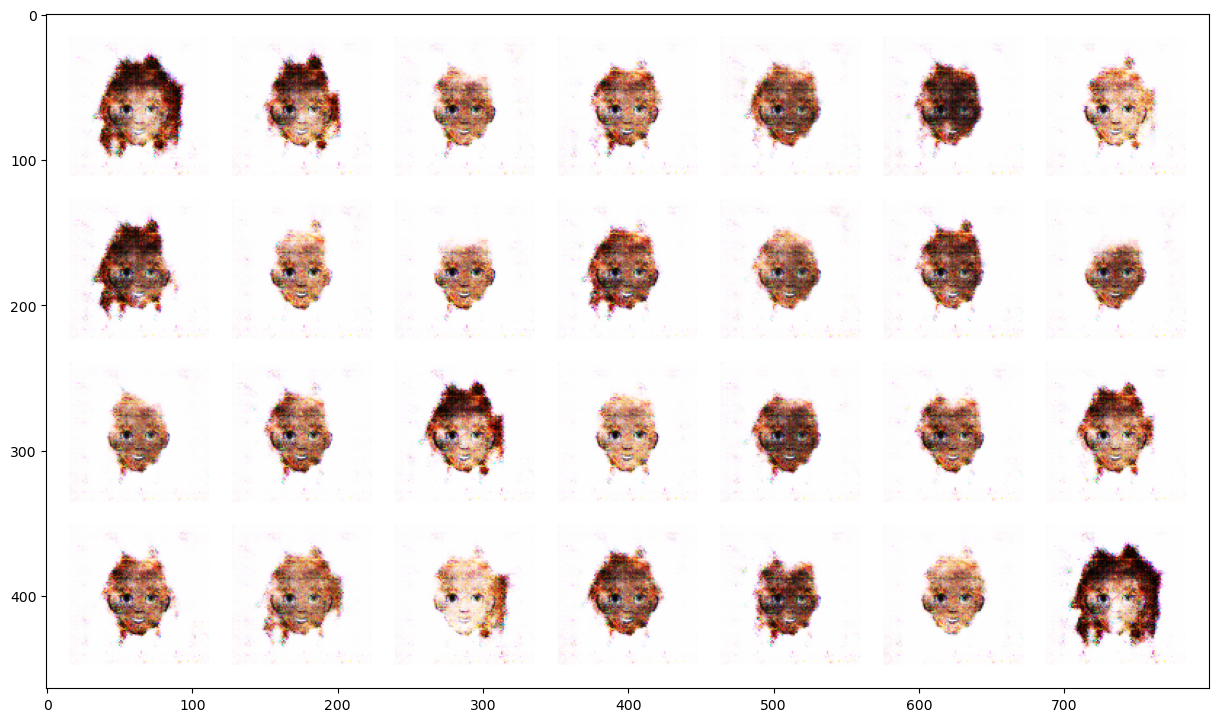

Epoch 1, gen loss=1.9503360986709595,disc loss=1.21488356590271
1/1 [==============================] - 1s 633ms/step


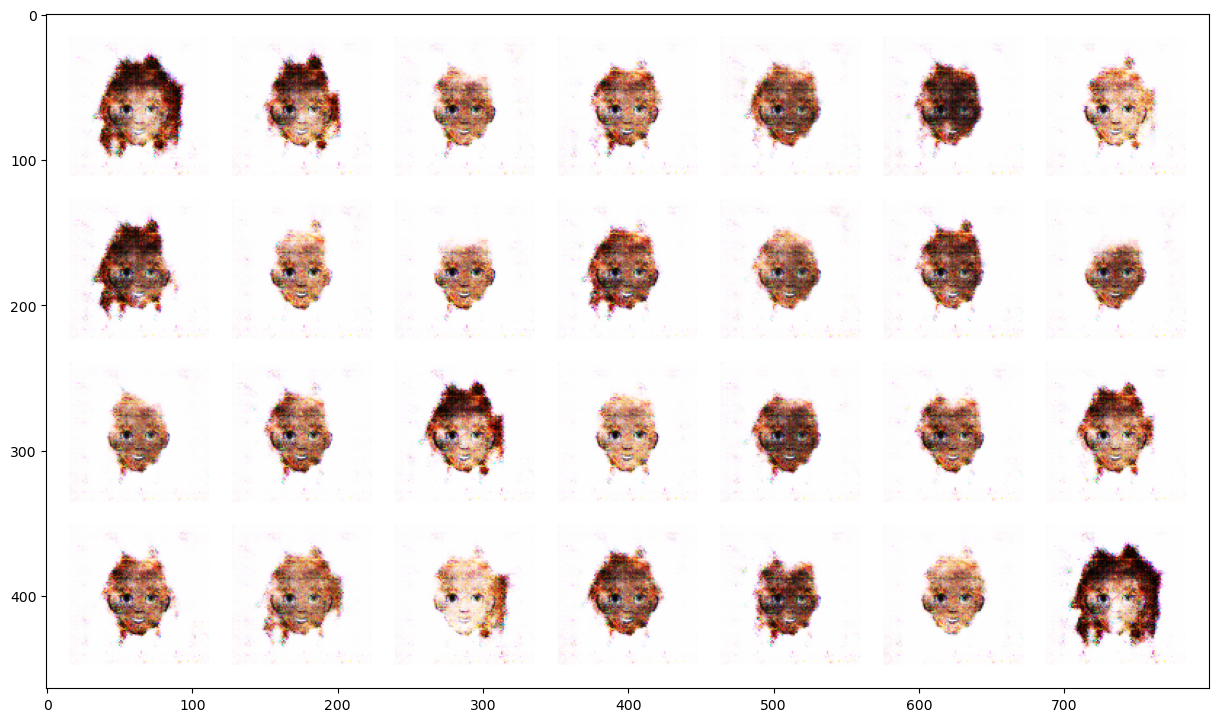

In [62]:
train(dataset, 1)

Generated image shape:  (1, 96, 96, 3)


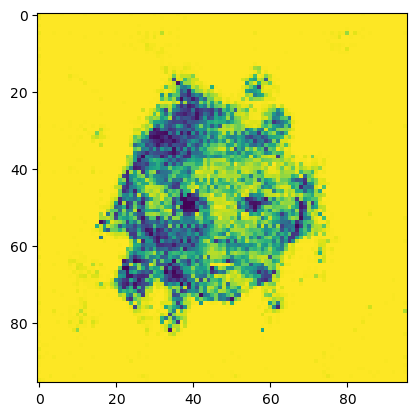

In [63]:
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)
print("Generated image shape: ", generated_image.shape)

plt.imshow(generated_image[0, :, :, 0])

Epoch 1, gen loss=1.8294464349746704,disc loss=1.1965588331222534
Epoch 1, gen loss=1.8294464349746704,disc loss=1.1965588331222534
1/1 [==============================] - 1s 639ms/step


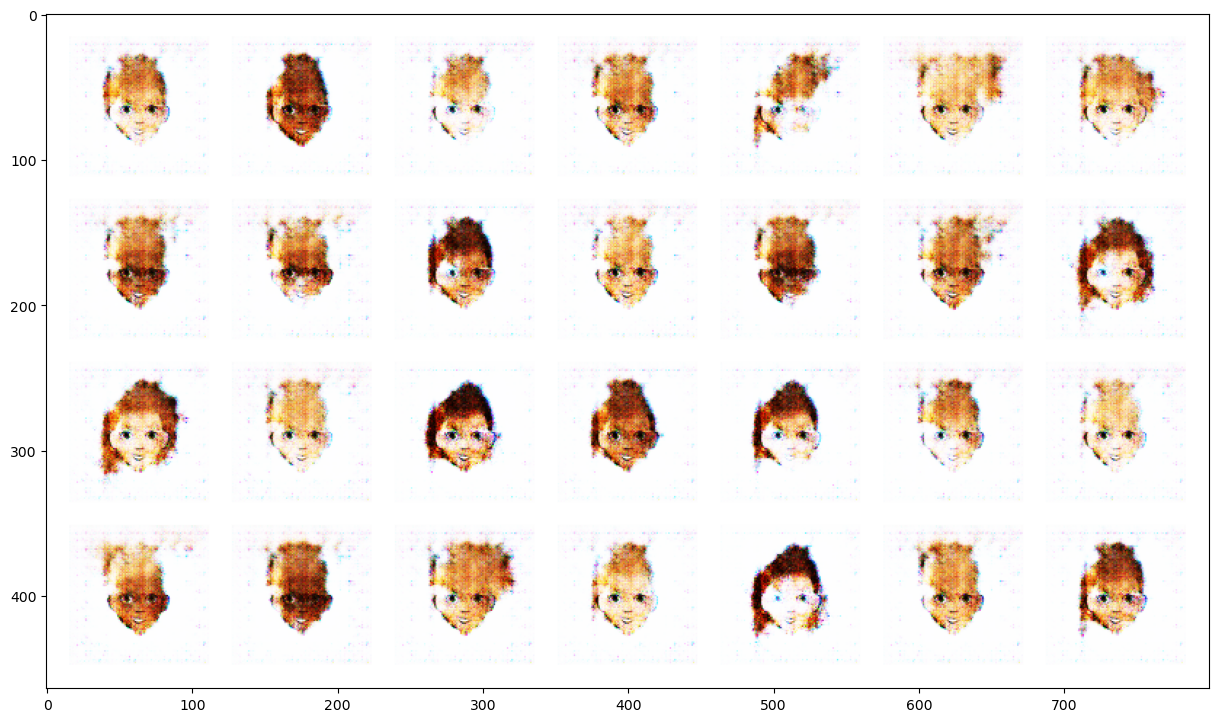

Epoch 1, gen loss=1.8294464349746704,disc loss=1.1965588331222534
1/1 [==============================] - 1s 617ms/step


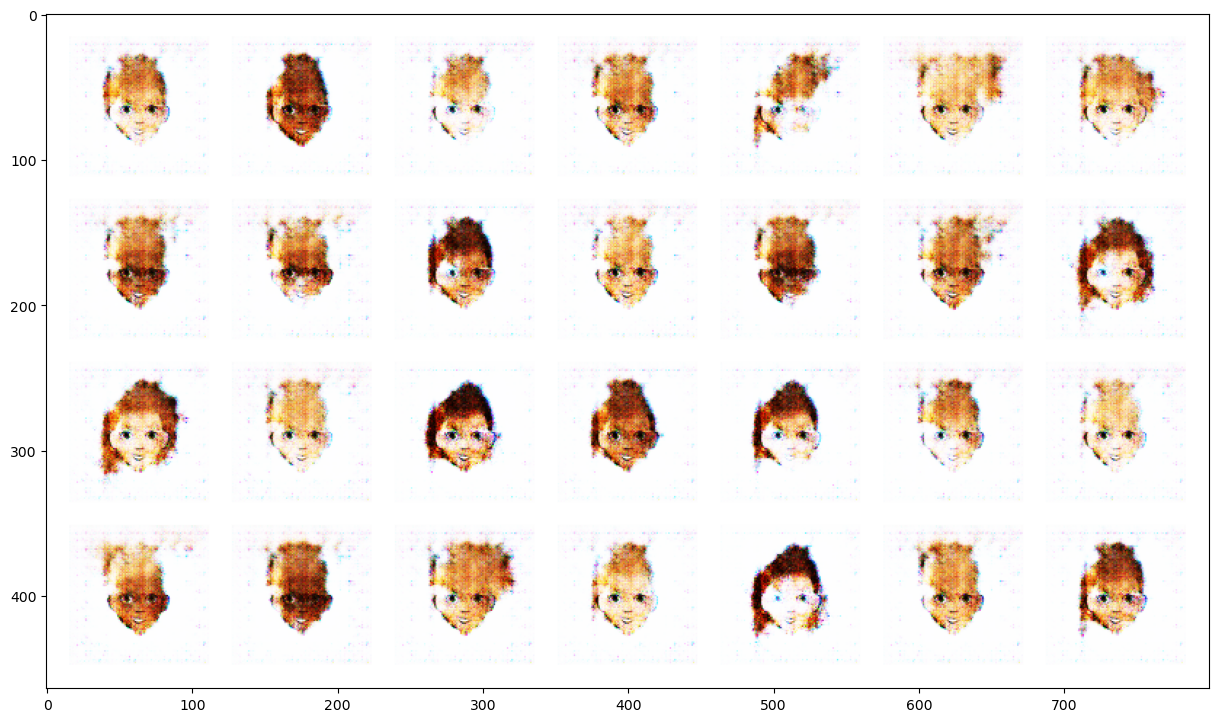

In [64]:
train(dataset, 1)

Generated image shape:  (1, 96, 96, 3)


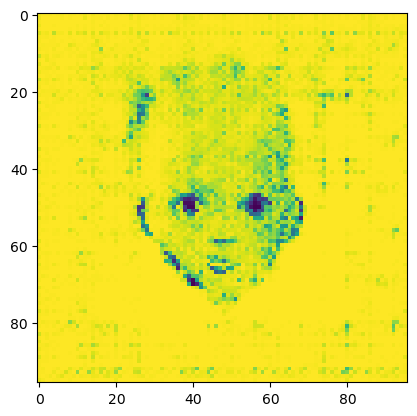

In [65]:
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)
print("Generated image shape: ", generated_image.shape)

plt.imshow(generated_image[0, :, :, 0])